# **TP: Implémentation d’une cascade de régresseurs pour l’alignement de points caractéristiques du visage**
- **Nom: Massyl Yanis HAMDI**
- **Num: 21118208**

## **Description**

L’objectif de ce TP est de réaliser une méthode d’alignement de points caractéristiques du visage inspirée de [1]. À l’issue du TP, vous devez fournir un notebook jupyter contenant :


## **1 Préparation des données**

##### **1.1 Téléchargement des données**



La base est constituée de 4 sous-ensembles de données (Helen, AFW, LFPW et iBug) dont les images (extension .jpg ou .png) et les annotations (extension .pts) sont contenues dans les répertoires du même nom. On a également des fichiers .txt contenant la liste des données à utiliser pour l'apprentissage - 300w_train_images.txt et 300w_train_landmarks.txt respectivement pour la liste des images et des annotations - ainsi que pour les tests.

In [1]:
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import glob
import cv2
from tqdm import tqdm
import matplotlib.patches as patches

# Initialisation des listes vides pour stocker les images et les repères (landmarks)
images = []
landmarks = []

# Ouvre les fichiers contenant les chemins des images et des repères
with open('datasets/300w_train_images.txt', 'r') as path_images, open('datasets/300w_train_landmarks.txt', 'r') as path_keypoints:
    # Utilise tqdm pour afficher une barre de progression pendant la boucle
    for pathimg, pathkey in tqdm(zip(path_images, path_keypoints), desc="Loading images and landmarks"):
        # Construit les chemins complets vers les images et les repères
        path = 'datasets/' + pathimg.strip()
        landmark = 'datasets/' + pathkey.strip()
        
        # Charge l'image depuis le chemin
        img = io.imread(path)
        
        # Ajoute l'image à la liste des images
        images.append(io.imread(path))
        
        # Charge les repères depuis le fichier et les ajoute à la liste des repères
        landmarks.append(np.loadtxt(landmark))

print("Done loading images and landmarks")


Loading images and landmarks: 3148it [03:29, 15.06it/s]


Done loading images and landmarks


##### **1.2 Visualisation des données**

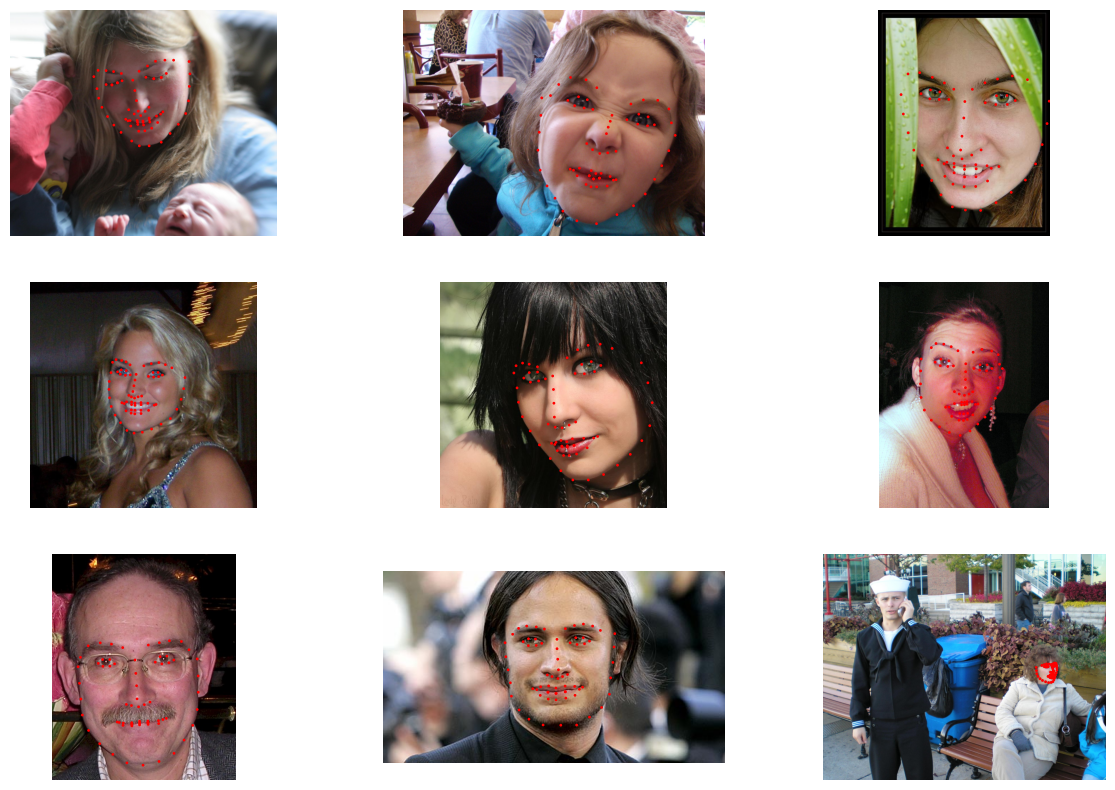

In [2]:
# On génère une liste d'indices d'images aléatoires de 0 à 3147 (3148 images au total), puis on les trie.
index = sorted(random.sample(range(len(images)), 9))

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# On parcourt les indices sélectionnés
for i, ind in enumerate(index):
    ax[(i//3), (i % 3)].imshow(images[ind], cmap='gray')
    landmark = landmarks[ind]
    # On affiche les repères en utilisant un nuage de points 
    ax[(i//3), (i % 3)].scatter(landmark[:, 0], landmark[:, 1], s=1, facecolors='none', edgecolors='r')
    ax[(i//3), (i % 3)].axis('off')


##### **1.3 Augmentation des données**

1.Calculer les paramètres de la boite englobante des points caractéristiques du visage

In [3]:
def bounding_box(image, keypoints, Expand_percent = None):
    """
    Calcule une boîte englobante autour des repères.

    Args:
        keypoints (numpy.ndarray): Tableau de repères avec deux colonnes représentant les coordonnées x et y.
        Expand_percent (int, facultatif): Pourcentage d'expansion de la boîte englobante. Par défaut, None.

    Returns:
        tuple: Un tuple contenant les informations de la boîte englobante : (coin_sup_gauche, largeur, hauteur, coin_inf_droit).
    """

    if isinstance(Expand_percent, int):
        Expand_percent = (Expand_percent/100) / 2
    else:
        Expand_percent = 0
    

    if (len(image.shape) == 3):
        image_width, image_height, _ = image.shape
    else :
        image_width, image_height = image.shape


    
    # Calcul des coordonnées du coin supérieur gauche de la boîte englobante
    coin_sup_gauche = (
        np.clip(keypoints[:, 0].min() - abs(keypoints[:, 0].max() - keypoints[:, 0].min()) * Expand_percent, a_min= 0, a_max=None),
        np.clip(keypoints[:, 1].min() - abs(keypoints[:, 1].max() - keypoints[:, 1].min()) * Expand_percent, a_min= 0, a_max=None)
    )

    # Calcul des coordonnées du coin inférieur droit de la boîte englobante
    coin_inf_droit = (
        np.clip(keypoints[:, 0].max() + abs(keypoints[:, 0].max() - keypoints[:, 0].min()) * Expand_percent, a_min=None, a_max=image_height),
        np.clip(keypoints[:, 1].max() + abs(keypoints[:, 1].max() - keypoints[:, 1].min()) * Expand_percent, a_min=None, a_max=image_width)
    )

    # Calcul de la largeur et de la hauteur de la boîte englobante
    largeur = coin_inf_droit[0] - coin_sup_gauche[0]
    hauteur = coin_inf_droit[1] - coin_sup_gauche[1]

    return coin_sup_gauche, largeur, hauteur, coin_inf_droit

Affichage de quelque boite englobante des points caractéristiques du visage

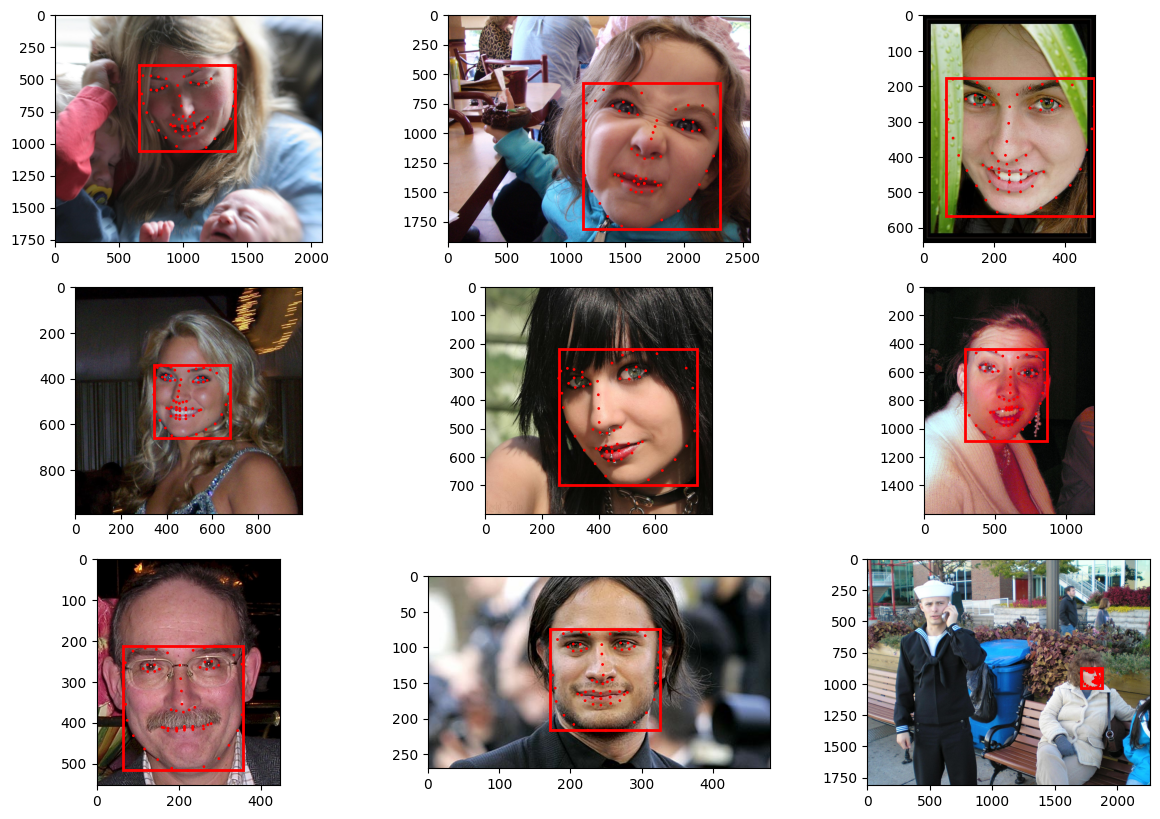

In [4]:
# Crée une grille de sous-graphiques de 3 lignes et 3 colonnes avec une taille de figure spécifiée
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# Itère sur les indices sélectionnés aléatoirement
for i, ind in enumerate(index):
    ax[(i//3), (i % 3)].imshow(images[ind], cmap='gray')
    landmark = landmarks[ind]
    ax[(i//3), (i % 3)].scatter(landmark[:, 0], landmark[:, 1], s=1, facecolors='none', edgecolors='r')
    # Calcule les informations de la boîte englobante
    coin_sup_gauche, largeur, hauteur, coin_inf_droit = bounding_box(images[ind], landmark)
    rect = patches.Rectangle(coin_sup_gauche, largeur, hauteur, linewidth=2, edgecolor='r', facecolor='none')
    ax[(i//3), (i % 3)].add_patch(rect)
    # ax[(i//3), (i % 3)].axis('off')


2. Élargir cette boîte englobante de 30%, découper l’image avec ces nouvelles dimensions, redimensionner l’image en 128 ∗ 128 et enregistrer l’image.

In [5]:
# Crée le répertoire de sauvegarde s'il n'existe pas
save_dir = "./datasets/train_data_process"
os.makedirs(save_dir, exist_ok=True)

# Boucle sur toutes les images
for i in tqdm(range(len(images)), desc="Processing images"):
    # Récupère les repères et calcule la boîte englobante avec un pourcentage d'expansion de 30%
    landmark = landmarks[i]
    # Récupère la nouvelle image
    new_image = images[i]
    coin_sup_gauche, largeur, hauteur, coin_inf_droit = bounding_box(new_image, landmark, 30)

    
    # Recadre l'image en fonction de la boîte englobante
    image_cropped = new_image[int(coin_sup_gauche[1]):int(coin_inf_droit[1]), int(coin_sup_gauche[0]):int(coin_inf_droit[0])]

    
    # Redimensionne l'image à 128x128 pixels
    image_resized = cv2.resize(image_cropped, (128, 128))


    # Calcule les facteurs de redimensionnement
    if (len(image_cropped.shape) == 3) and (len(image_resized.shape) == 3):
        image_width, image_height, _ = image_cropped.shape
        newsize_w, newsize_h, _ = image_resized.shape
    else :
        image_width, image_height = image_cropped.shape
        newsize_w, newsize_h = image_resized.shape

    
    w_factor = image_width / newsize_w
    h_factor =  image_height / newsize_h

    # Ajuste les coordonnées des repères en fonction de la recadrage et de la redimension
    new_keypoint_cropped  = np.column_stack((np.array(landmark[:, 0]) - coin_sup_gauche[0], np.array(landmark[:, 1]) - coin_sup_gauche[1]))
    new_keypoint_resized = np.column_stack((new_keypoint_cropped[:, 0] / h_factor, new_keypoint_cropped[:, 1] / w_factor))

    # Définit les noms de fichier pour l'image et les repères
    fname_image = os.path.join(save_dir, f"train_data_process{str(i)}.jpg")
    fname_landmarks = os.path.join(save_dir, f"train_data_process{str(i)}.pts")

    # Sauvegarder
    io.imsave(fname_image, image_resized)
    np.savetxt(fname_landmarks, new_keypoint_resized)


Processing images: 100%|██████████| 3148/3148 [01:17<00:00, 40.84it/s] 


3. Calculer les coordonnées des points caractéristiques pour cette nouvelle image. La position des points constituera la vérité terrain (vous afficherez l’image et les points caractéristiques pour vérifier que ce prétraitement est effectif)


In [6]:
# images_proc = [io.imread(file) for file in glob.glob(f"datasets/data_processing/*.jpg")]    #les images sont desordonnées 
folder = "datasets/train_data_process"
train_images = []
train_landmarks = []

for i in tqdm(range(len(images)), desc="loading images and landmarks"):
    # Construire le nom de fichier de l'image
    filename_images = f"train_data_process{str(i)}.jpg"
    filename_landmarks = f"train_data_process{str(i)}.pts"
    
    if os.path.isfile(os.path.join(folder, filename_images)):
        # Charger l'image et l'ajouter à la liste
        train_images.append(io.imread(os.path.join(folder, filename_images)))

    if os.path.isfile(os.path.join(folder, filename_landmarks)):
        # Charger l'image et l'ajouter à la liste
        train_landmarks.append(np.loadtxt(os.path.join(folder, filename_landmarks)))

loading images and landmarks: 100%|██████████| 3148/3148 [00:39<00:00, 78.81it/s]


Images et landmarks avant le processing:

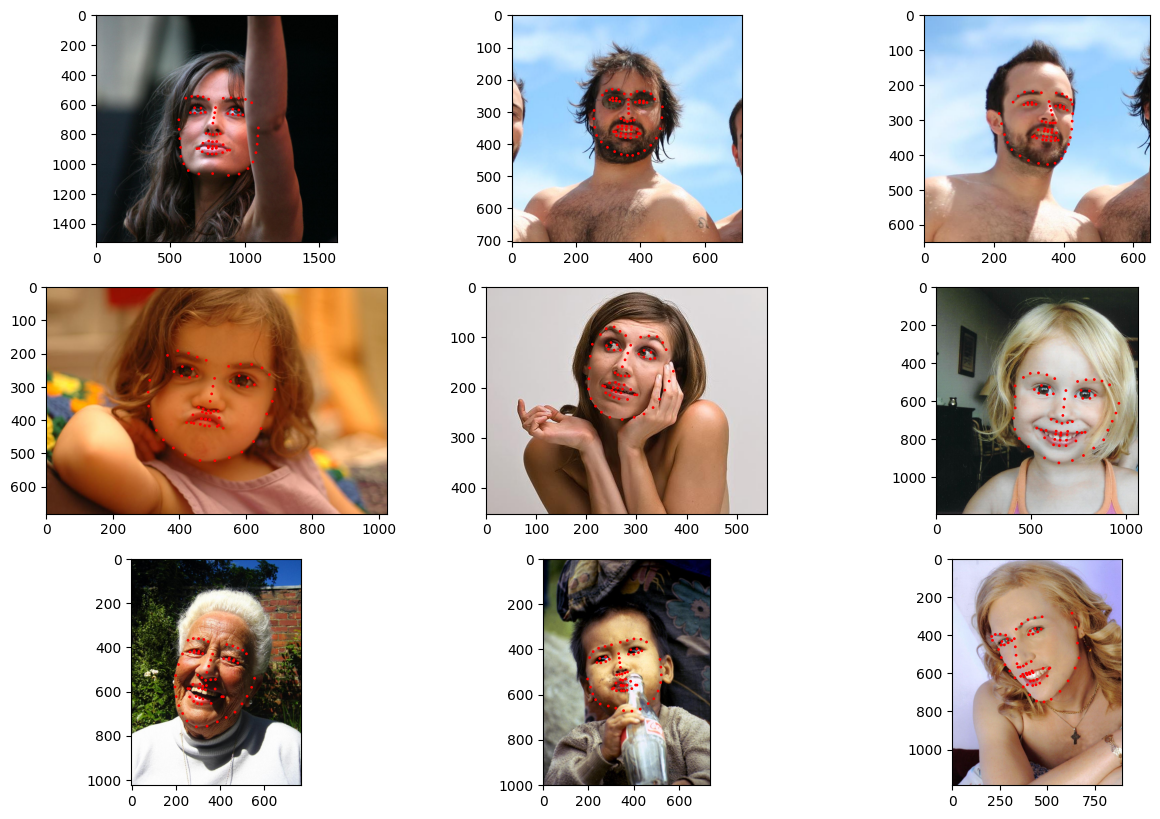

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# On parcourt les indices sélectionnés
for i in range(9):
    ax[(i//3), (i % 3)].imshow(images[i], cmap='gray')
    landmark = landmarks[i]
    ax[(i//3), (i % 3)].scatter(landmark[:, 0], landmark[:, 1], s=1, facecolors='none', edgecolors='r')

Images et landmarks apres le processing:

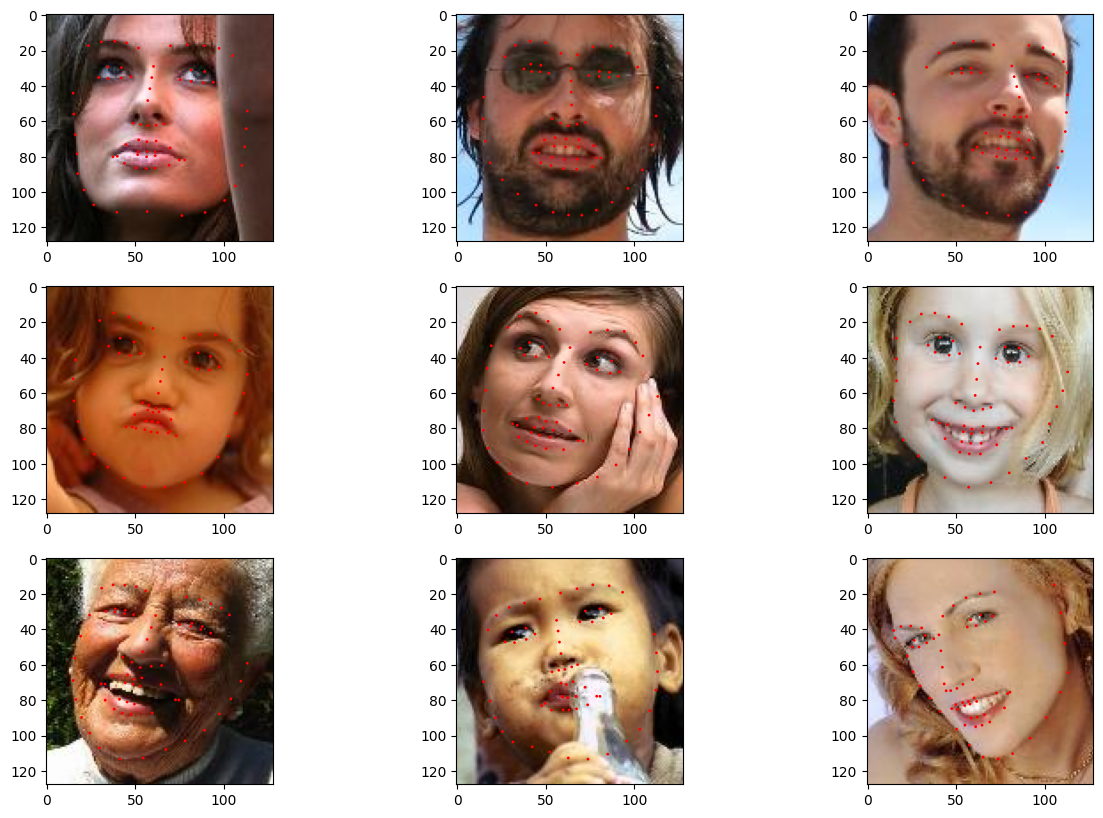

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# On parcourt les indices sélectionnés
for i in range(9):
    ax[(i//3), (i % 3)].imshow(train_images[i], cmap='gray')
    landmark = train_landmarks[i]
    ax[(i//3), (i % 3)].scatter(landmark[:, 0], landmark[:, 1], s=1, facecolors='none', edgecolors='r')

4. Calculer la position moyenne des points caractéristique sur l’ensemble des images de la base d’apprentissage

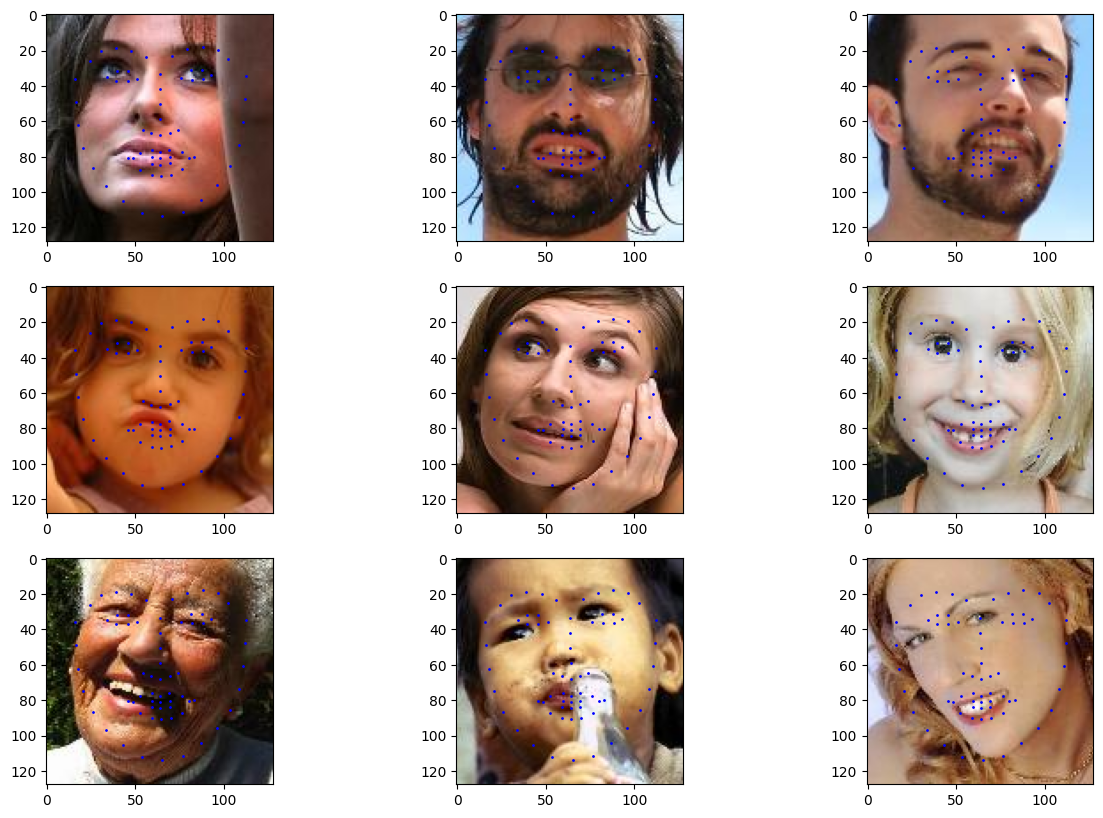

In [9]:
average_train_landmarks  = np.mean(np.array(train_landmarks),axis=0)
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
for i in range(9):
    ax[(i//3), (i % 3)].imshow(train_images[i], cmap='gray')
    ax[(i//3), (i % 3)].scatter(average_train_landmarks[:, 0], average_train_landmarks[:, 1], s=1, facecolors='b')

5. Générer 10 perturbations aléatoires de la position des points caractéristiques (en translation et en facteur d’échelle) et enregistrer chacune de ces réalisations. L’amplitude de
ces déformations sera de ±20% pour le facteur d’échelle et ±20px pour les translations
(indépendamment en x et y). Pourquoi applique-t-on ces transformations ? Proposer une
méthode automatique pour déterminer l’amplitude de ces déplacements ?

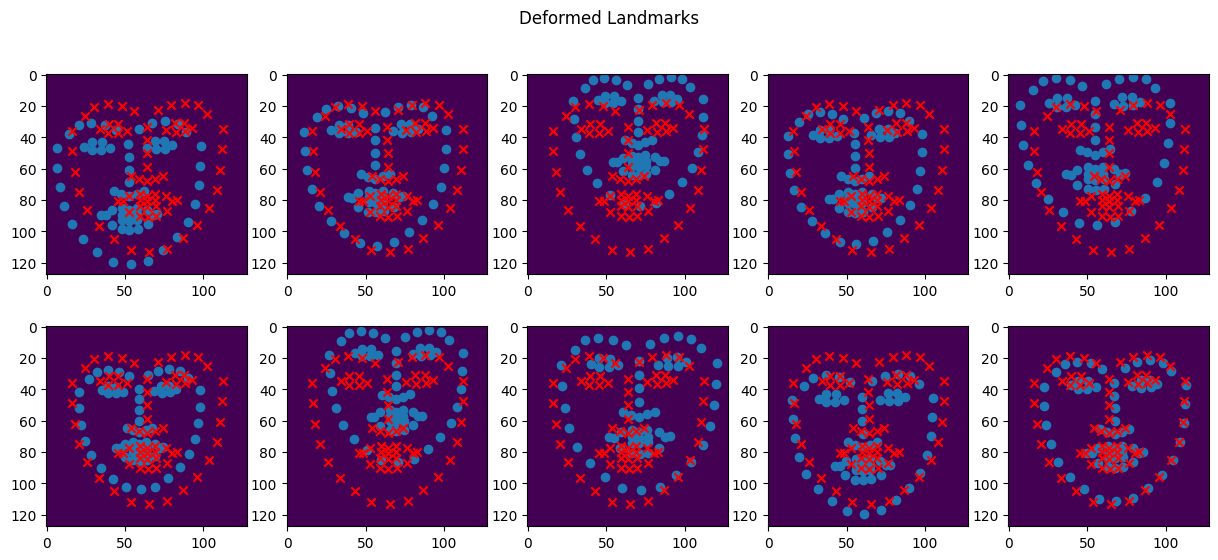

In [10]:
# Nombre de perturbations souhaitées
num_perturbations = 10

# Liste pour stocker les réalisations déformées
deformed_landmarks_list = []


fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

# Boucle sur le nombre de perturbations
for i in range(num_perturbations):
    while True:
        # Génère des valeurs aléatoires pour la translation en x et y dans la plage de ±20 pixels
        translation_x = np.random.uniform(-20, 20)
        translation_y = np.random.uniform(-20, 20)

        # Génère une valeur aléatoire pour le facteur d'échelle dans la plage de ±20%
        scale_factor = np.random.uniform(-0.2, 0.2)

        # Applique la translation et le facteur d'échelle à chaque point caractéristique
        deformed_landmarks = average_train_landmarks + np.array([translation_x, translation_y])
        deformed_landmarks = deformed_landmarks - (deformed_landmarks * scale_factor)

        # Vérifie si tous les points déformés sont à l'intérieur des limites de l'image
        if np.all((deformed_landmarks >= 0) & (deformed_landmarks < 128)):
            break

    # Stocke les nouvelles coordonnées déformées
    deformed_landmarks_list.append(deformed_landmarks)

    # Affiche ou enregistre les réalisations déformées selon vos besoins
    # Vous pouvez remplacer plt.show() par le code pour sauvegarder les réalisations déformées

    # Affiche la réalisation déformée
    ax[(i//5), (i % 5)].imshow(np.zeros((128,128), dtype=np.uint8))
    ax[(i//5), (i % 5)].scatter(deformed_landmarks[:, 0], deformed_landmarks[:, 1], label='Deformed Landmarks')
    ax[(i//5), (i % 5)].scatter(average_train_landmarks[:, 0], average_train_landmarks[:, 1], label='Mean Landmarks', marker='x', color='red')
fig.suptitle('Deformed Landmarks')
# Convertit la liste en un tableau NumPy
deformed_landmarks = np.array(deformed_landmarks_list)

Ces transformations sont souvent utilisées pour augmenter la variabilité des données d'apprentissage, ce qui peut être bénéfique lors de l'entraînement de modèles d'apprentissage automatique.
Elles permettent au modèle d'apprendre à être plus robuste envers les variations dans les données réelles, ce qui peut améliorer les performances du modèle sur de nouvelles données.
Ces déformations simulent des variations dans la pose, l'échelle et la position des objets, ce qui peut être particulièrement utile dans des applications telles que la vision par ordinateur.

## **2 Apprentissage d’un régresseur simple**

##### **2.1 Extraction de caractéristiques image**

1. Pourquoi ne peut-on pas utiliser directement les valeurs des pixels de l’image comme
représentation ?


Car elles ne contiennent pas suffisamment d'informations pour capturer la structure et les caractéristiques du point. En utilisant les valeurs des pixels voisins, on peut prendre en compte les relations spatiales entre les pixels et obtenir une représentation plus riche et significative de l'image. Cela permet de mieux capturer les contours, les textures et les motifs présents dans l'image.

2. Créer, pour chaque point caractéristique courant du modèle moyen, un objet
cv2.keyPoint en spécifiant ses coordonnées, et une taille de fenêtre (paramètre size, réglant
le diamètre du voisinage) de 20 pixels.

In [11]:
def key_points(average_landmarks, window_size = 20):
    keypoints_list= []
    for point in average_landmarks:
        x, y = point    
        # Création d'un objet cv2.KeyPoint pour chaque point caractéristique
        keypoint = cv2.KeyPoint(x, y, window_size)

        # Ajout de l'objet cv2.KeyPoint à la liste
        keypoints_list.append(keypoint)
        
    return keypoints_list

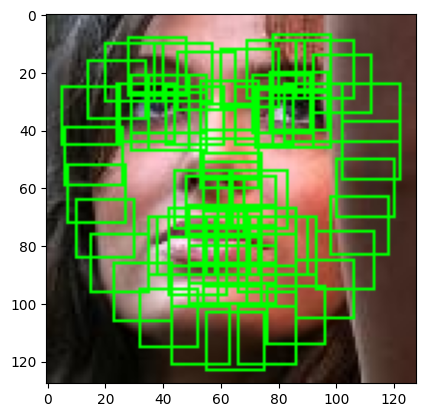

In [12]:

keypoints = key_points(average_train_landmarks,20)

img = train_images[0].copy()
for keypoint in keypoints:
    x, y = int(keypoint.pt[0]), int(keypoint.pt[1])
    size = int(keypoint.size)
    img = cv2.rectangle(img, (x - size // 2, y - size // 2), (x + size // 2, y + size // 2), (0, 255, 0), 1)

plt.imshow(img)
plt.show()

3. Utiliser la fonction sift.compute de OpenCV pour calculer un descripteur SIFT au voisinage de chaque point caractéristique. Quelle est la dimensionnalité de chacun de ces descripteurs ?
4. Pour chaque image, concaténer l’ensemble des descripteurs obtenus pour tous les points caractéristiques. Quelle est la dimension de ce descripteur ?

In [13]:
descriptors = []
for ind in range(len(train_images)):
    for i in range(10):
        sift = cv2.SIFT_create()
        keypoints = key_points(deformed_landmarks[i],20)
        # Apply the sift algorithm
        kp, descriptor = sift.compute(train_images[ind], keypoints)
        # Store the descriotors
        descriptors.append( descriptor.flatten())

In [14]:
# Convertit la liste en un tableau NumPy
descriptors_array = np.array(descriptors)
print("Dimensionnalité de chaque descripteur SIFT:", descriptors_array.shape[1])
print("La dimension du descripteur SIFT:", descriptors_array.shape)

Dimensionnalité de chaque descripteur SIFT: 8704
La dimension du descripteur SIFT: (31480, 8704)


##### **2.2 Réduction de la dimensionalité**

1. Quel est l’intérêt principal de la réduction de la dimensionnalité en machine learning ?Quelles sont les principales méthodes de réduction de la dimensionnalité ?


La réduction de la dimensionnalité en apprentissage automatique est une technique qui vise à réduire le nombre de caractéristiques ou de variables dans un ensemble de données tout en préservant au mieux les informations essentielles. Cela peut être particulièrement utile dans plusieurs situations :

Gain de temps de calcul : En réduisant la dimensionnalité, on peut accélérer les algorithmes d'apprentissage, car ils ont moins de caractéristiques à traiter.

Évitement de la malédiction de la dimensionnalité : Dans des espaces de grande dimension, la densité des données peut devenir très clairsemée, ce qui peut entraîner des problèmes tels que le surajustement (overfitting) et la difficulté à généraliser à de nouvelles données.

Visualisation : La réduction de la dimensionnalité peut faciliter la visualisation des données en les ramenant à un espace à deux ou trois dimensions, permettant ainsi une compréhension plus intuitive.

Élimination du bruit et des redondances : En éliminant les caractéristiques redondantes ou peu informatives, on peut améliorer la qualité des données et réduire les effets de bruit.

Amélioration de la généralisation : En réduisant la dimensionnalité, on peut réduire le risque de surajustement, ce qui peut conduire à des modèles plus généralisables.

Les principales méthodes de réduction de la dimensionnalité comprennent :

Analyse en composantes principales (PCA) : PCA est une technique linéaire qui transforme les données en un nouvel ensemble de variables (composantes principales) qui capturent la variance maximale dans les données.

2. Utiliser l’analyse en composante principale (ACP ou PCA en anglais - librairies OpenCV ou skimage, au choix) en conservant 98% de la variance totale des descripteurs.


In [ ]:
pca = PCA()
pca.fit_transform(descriptors)

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 1000)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(400, c='b')
plt.axhline(0.98, c='r')
plt.show()

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.98)
X0_ = pca.fit_transform(descriptors)

3. Quelles sont les dimensions de la matrice X0 obtenue par réduction de la dimensionnalité?

In [16]:
A0 = pca.components_
desc = A0 @ np.array(descriptors).T
print("The new dataset dimension :",   desc.shape)

The new dataset dimension : (351, 31480)


In [17]:
A0 = pca.components_
X0_.shape ,A0.shape

((31480, 351), (351, 8704))

##### **2.3 Estimation du déplacement**

In [18]:
def delta(train_landmarks,deformed_landmarks):
    delta =  np.zeros((np.array(train_landmarks).shape[0]*10, 136))
    for i in range(31480):
        delta[i, :] = train_landmarks[i//10].flatten() - deformed_landmarks[i%10].flatten()
    return delta

In [19]:
delt = delta(train_landmarks,deformed_landmarks)

In [20]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

reg.fit(X0_, delt)

R0 = reg.coef_
b0 = reg.intercept_

In [21]:
from sklearn.metrics import mean_absolute_error
delt_regression =  np.dot(X0_, R0.T) + b0

In [22]:
mae = mean_absolute_error(delt, delt_regression)

In [24]:
delt_regression = delt_regression.reshape(31480, 68, 2)

In [23]:
print(mae)

3.5677422358048094


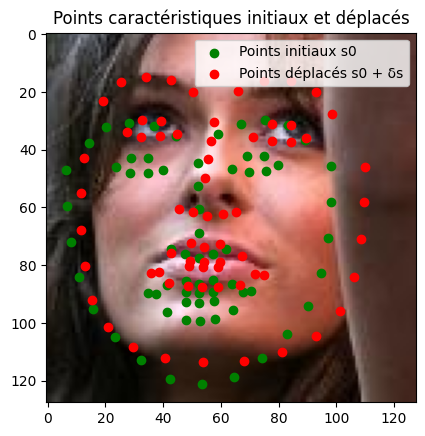

In [25]:
# Afficher les points caractéristiques initiaux s0 (en vert) et les points déplacés s0 + δs (en rouge)
plt.imshow(train_images[0])
plt.scatter(deformed_landmarks[0][:, 0], deformed_landmarks[0][:, 1], color='green', label='Points initiaux s0')
plt.scatter((deformed_landmarks[0] + delt_regression)[0][:, 0], (deformed_landmarks[0] + delt_regression)[0][:, 1], color='red', label='Points déplacés s0 + δs')
plt.legend()
plt.title('Points caractéristiques initiaux et déplacés')
plt.show()